### Capstone Project - The Battle of Neighborhoods - NY (week2)
### : Compare cities for the Coffee shop Biz investors

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.18.1               |             py_0          51 KB  conda-forge
    openssl-1.0.2p             |       h470a237_2         3.1 MB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0         conda-forge
    geopy:         1.18.1-py_0       conda-forge

The following packages will be UPDATED:

    openssl:       1.0.2p-h470a237_1 conda-forge --> 1.0.2p-h470a237_2 conda-forge


geopy-1.18.1         | 51 KB     | ##################################### | 100% 
ope

## 1. Download and Explore Dataset
NY City has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.
I will reuse file that I downloaded before, so I can simply run a `wget` command and access the data.

In [2]:
with open('newyork_data.json') as json_data:
    nycafe_data = json.load(json_data)

#### Load and explore the data

In [3]:
neighborhoods_data = nycafe_data['features']

In [4]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a *pandas* dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [6]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Manhattan, New York City.

For data analysis purposes, I will simplify segment and cluster only the neighborhoods in Manhattan where is center of Korea culture in NY city.   So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [10]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [11]:
address = 'Manhattan, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Manhattan are 40.7900869, -73.9598295.


Visualizat Manhattan, NewYokr the neighborhoods in it.

In [12]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  

map_manhattan

#### Define Foursquare Credentials and Version

In [88]:
CLIENT_ID = '-------'     
CLIENT_SECRET = '------' 
VERSION = '20180605'
LIMIT = 30

CATID_coff = '4bf58dd8d48988d1e0931735,4bf58dd8d48988d16d941735'
CATID_Kor = '4bf58dd8d48988d113941735'
#CATID_Coffee  = '4bf58dd8d48988d1e0931735'
#CATID_Cafe    = '4bf58dd8d48988d16d941735'
#                  4bf58dd8d48988d1dc931735 (Tea room)

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('CategoryID coff   :' + CATID_coff)
print('CategoryID KorRest  :' + CATID_Kor)

Your credentails:
CLIENT_ID: -------
CLIENT_SECRET:------
CategoryID coff   :4bf58dd8d48988d1e0931735,4bf58dd8d48988d16d941735
CategoryID KorRest  :4bf58dd8d48988d113941735


In [14]:
LIMIT=100
radius=500
neighborhood_latitude=40.7900869
neighborhood_longitude=-73.9598295
# latitude, longitude

## 2. Explore Neighborhoods in Manhattan

In [16]:
def getNearbyCoffeeVenues(names, latitudes, longitudes, radius=500):

    CATID_coff = '4bf58dd8d48988d1e0931735,4bf58dd8d48988d16d941735'
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url_coff = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            CATID_coff,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url_coff).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
def getNearbyKoreanVenues(names, latitudes, longitudes, radius=500):

    CATID_Kor = '4bf58dd8d48988d113941735'
    venues_listK=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url_Kor = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            CATID_Kor,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url_Kor).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_listK.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venuesK = pd.DataFrame([item for venue_listK in venues_listK for item in venue_listK])
    nearby_venuesK.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venuesK)

In [18]:
manhattan_venues = getNearbyCoffeeVenues(names=manhattan_data['Neighborhood'],
                                 latitudes=manhattan_data['Latitude'],
                                 longitudes=manhattan_data['Longitude'])
manhattan_venues.head()

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop
1,Marble Hill,40.876551,-73.910660,Starbucks,40.873755,-73.908613,Coffee Shop
2,Marble Hill,40.876551,-73.910660,Starbucks,40.873234,-73.908730,Coffee Shop
3,Chinatown,40.715618,-73.994279,Yaya Tea Garden,40.716177,-73.994902,Tea Room
4,Chinatown,40.715618,-73.994279,Little Canal,40.714317,-73.990361,Coffee Shop


In [19]:
manhattan_venuesK = getNearbyKoreanVenues(names=manhattan_data['Neighborhood'],
                                 latitudes=manhattan_data['Latitude'],
                                 longitudes=manhattan_data['Longitude'])
manhattan_venuesK.head()

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Korean School Of New York,40.878851,-73.912671,Language School
1,Chinatown,40.715618,-73.994279,Tofu Tofu,40.717605,-73.995304,Korean Restaurant
2,Chinatown,40.715618,-73.994279,Kimbap,40.718208,-73.995888,Korean Restaurant
3,Chinatown,40.715618,-73.994279,99 Favor Taste 99號餐廳,40.717756,-73.992515,Hotpot Restaurant
4,Chinatown,40.715618,-73.994279,To Two Boonsik,40.715517,-73.993932,Korean Restaurant


In [20]:
print(manhattan_venues.shape)
#manhattan_venues.head()

(1339, 7)


In [21]:
print(manhattan_venuesK.shape)
#manhattan_venues.head()

(233, 7)


Concact queried data file from Foursquare. (1. Cafe & coffeeshop venues,  2. Korean restaurants venues)

In [22]:
manhattan_venues_coffKor=pd.concat([manhattan_venues,manhattan_venuesK], axis=0)

In [27]:
print(manhattan_venues_coffKor.shape)

(1572, 7)


In [28]:
manhattan_venues_coffKor.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop
1,Marble Hill,40.876551,-73.910660,Starbucks,40.873755,-73.908613,Coffee Shop
2,Marble Hill,40.876551,-73.910660,Starbucks,40.873234,-73.908730,Coffee Shop
3,Chinatown,40.715618,-73.994279,Yaya Tea Garden,40.716177,-73.994902,Tea Room
4,Chinatown,40.715618,-73.994279,Little Canal,40.714317,-73.990361,Coffee Shop


In [29]:
# manhattan_venues.groupby('Neighborhood').count()
manhattan_venues_grp = manhattan_venues_coffKor.groupby('Neighborhood').count()
manhattan_venues_grp.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,32,32,32,32,32,32
Carnegie Hill,31,31,31,31,31,31
Central Harlem,3,3,3,3,3,3
Chelsea,55,55,55,55,55,55
Chinatown,65,65,65,65,65,65


In [30]:
manhattan_venues_grp.shape

(40, 6)

In [31]:
print('There are {} uniques categories - coffee & Korean.'.format(len(manhattan_venues_grp['Venue Category'].unique())))

There are 32 uniques categories - coffee & Korean.


## 3. Analyze Each Neighborhood's coffee shop & Korean restaurants data.

In [33]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues_coffKor[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues_coffKor['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,Bakery,Bar,Burger Joint,Cafeteria,Café,Chinese Restaurant,Church,Coffee Shop,College Classroom,Filipino Restaurant,Food Truck,Fried Chicken Joint,Gastropub,Gourmet Shop,Hotpot Restaurant,Japanese Restaurant,Karaoke Bar,Korean Restaurant,Language School,Miscellaneous Shop,Noodle House,Office,Sake Bar,Sushi Restaurant,Taco Place,Tea Room,Wings Joint
0,Marble Hill,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Chinatown,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
manhattan_onehot.shape

(1572, 30)

Reselect correct data from above merged file.  

In [35]:
#manhattan_venues_cnt = pd.DataFrame(manhattan_venues_grp['Venue'])
manhattan_onehot_fix=pd.DataFrame(manhattan_onehot[['Neighborhood','Café','Coffee Shop','Korean Restaurant']])
manhattan_onehot_fix.head()

,Neighborhood,Café,Coffee Shop,Korean Restaurant
0,Marble Hill,0,1,0
1,Marble Hill,0,1,0
2,Marble Hill,0,1,0
3,Chinatown,0,0,0
4,Chinatown,0,1,0


In [36]:
manhattan_onehot_fix.shape

(1572, 4)

Goruping by each Neighborhood for NY city.

In [38]:
manhattan_grouped = manhattan_onehot_fix.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Café,Coffee Shop,Korean Restaurant
0,Battery Park City,0.343750,0.625000,0.000000
1,Carnegie Hill,0.419355,0.548387,0.032258
2,Central Harlem,0.666667,0.333333,0.000000
3,Chelsea,0.345455,0.454545,0.054545
4,Chinatown,0.369231,0.338462,0.092308


Counting total venues by each Neighborhood to caculate by categories.

In [39]:
manhattan_venues_grp = manhattan_venues_grp.reset_index()
manhattan_venues_cnt = pd.DataFrame(manhattan_venues_grp['Venue'])
#.reset_index()
manhattan_venues_cnt.head()

,Venue
0,32
1,31
2,3
3,55
4,65


Concat above two files.

In [40]:
frames = [manhattan_grouped, manhattan_venues_cnt]
manhattan_merged = pd.concat(frames,axis=1, sort=True)
manhattan_merged.head()

,Neighborhood,Café,Coffee Shop,Korean Restaurant,Venue
0,Battery Park City,0.343750,0.625000,0.000000,32
1,Carnegie Hill,0.419355,0.548387,0.032258,31
2,Central Harlem,0.666667,0.333333,0.000000,3
3,Chelsea,0.345455,0.454545,0.054545,55
4,Chinatown,0.369231,0.338462,0.092308,65


Sum of 'Cafe' & 'Coffee shop' columns as new 'CoffeeShop & Cafe' column. 

In [41]:
manhattan_merged_coffee = pd.DataFrame(manhattan_merged)
#manhattan_merged_coffee = manhattan_merged
manhattan_merged_coffee['CoffeeShop & Cafe'] = manhattan_merged_coffee['Coffee Shop'] + manhattan_merged_coffee['Café']
manhattan_merged_coffee.head()

,Neighborhood,Café,Coffee Shop,Korean Restaurant,Venue,CoffeeShop & Cafe
0,Battery Park City,0.343750,0.625000,0.000000,32,0.968750
1,Carnegie Hill,0.419355,0.548387,0.032258,31,0.967742
2,Central Harlem,0.666667,0.333333,0.000000,3,1.000000
3,Chelsea,0.345455,0.454545,0.054545,55,0.800000
4,Chinatown,0.369231,0.338462,0.092308,65,0.707692


Caculate venue counts by each 'Coffeeshop & Cafe' and 'Korean restaurants'

In [42]:
manhattan_merged_coffee['CoffeeShop & Cafe'] = manhattan_merged_coffee['CoffeeShop & Cafe'] * manhattan_merged_coffee['Venue']
manhattan_merged_coffee['Korean Restaurant'] = manhattan_merged_coffee['Korean Restaurant'] * manhattan_merged_coffee['Venue']
manhattan_merged_coffee.head()

,Neighborhood,Café,Coffee Shop,Korean Restaurant,Venue,CoffeeShop & Cafe
0,Battery Park City,0.343750,0.625000,0.0,32,31.0
1,Carnegie Hill,0.419355,0.548387,1.0,31,30.0
2,Central Harlem,0.666667,0.333333,0.0,3,3.0
3,Chelsea,0.345455,0.454545,3.0,55,44.0
4,Chinatown,0.369231,0.338462,6.0,65,46.0


In [43]:
#manhattan_venues_cnt = pd.DataFrame(manhattan_venues_grp['Venue'])
manhattan_coffKor_sum=pd.DataFrame(manhattan_merged_coffee[['Neighborhood','CoffeeShop & Cafe','Korean Restaurant']])
manhattan_coffKor_sum

,Neighborhood,CoffeeShop & Cafe,Korean Restaurant
0,Battery Park City,31.0,0.0
1,Carnegie Hill,30.0,1.0
2,Central Harlem,3.0,0.0
3,Chelsea,44.0,3.0
4,Chinatown,46.0,6.0
5,Civic Center,36.0,3.0
6,Clinton,34.0,2.0
7,East Harlem,5.0,0.0
8,East Village,42.0,5.0
9,Financial District,65.0,3.0


## 4. Cluster veneus (coffee shop & Korean restaurants) by Neighborhoods 

#### Initialize *k*-means - plot data points

In [44]:
# data
coff = manhattan_merged_coffee['CoffeeShop & Cafe']
KorR = manhattan_merged_coffee['Korean Restaurant']

print('Datapoints defined!')

Datapoints defined!


In [135]:
def plot_points(centroids=None, colors='g', figure_title=None):
    # plot the figure
    fig = plt.figure(figsize=(15, 10))  # create a figure object
    #fig = plt.figure(figsize=(100, 100))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    
    centroid_colors = ['bx', 'rx','yx','gx']
    if centroids:
        for (i, centroid) in enumerate(centroids):
            ax.plot(centroid[0], centroid[1], centroid_colors[i], markeredgewidth=5, markersize=20)
    plt.scatter(coff, KorR, s=500, c=colors)
    
    # define the ticks
    xticks = np.linspace(0, 100, 11, endpoint=True)
    yticks = np.linspace(0, 100, 11, endpoint=True)

    # fix the horizontal axis
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # add tick labels
    xlabels = xticks
    ax.set_xticklabels(xlabels)
    ylabels = yticks
    ax.set_yticklabels(ylabels)

    # style the ticks
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params('both', length=2, width=1, which='major', labelsize=15)
    
    # add labels to axes
    ax.set_xlabel('coff', fontsize=20)
    ax.set_ylabel('KorR', fontsize=20)
    
    # add title to figure
    ax.set_title(figure_title, fontsize=24)

    plt.show()

print('plot_points function defined!')

plot_points function defined!


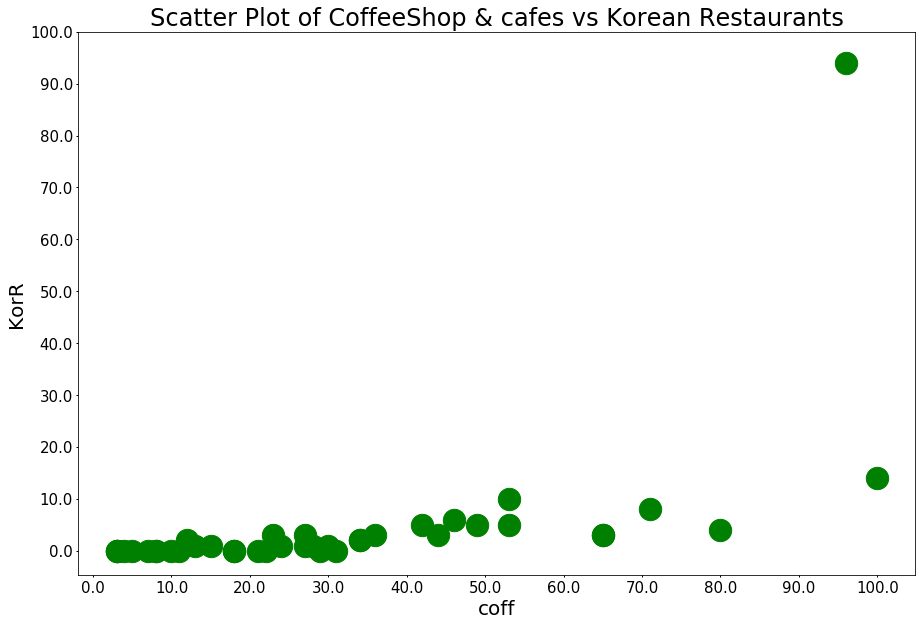

In [136]:
plot_points(figure_title='Scatter Plot of CoffeeShop & cafes vs Korean Restaurants')

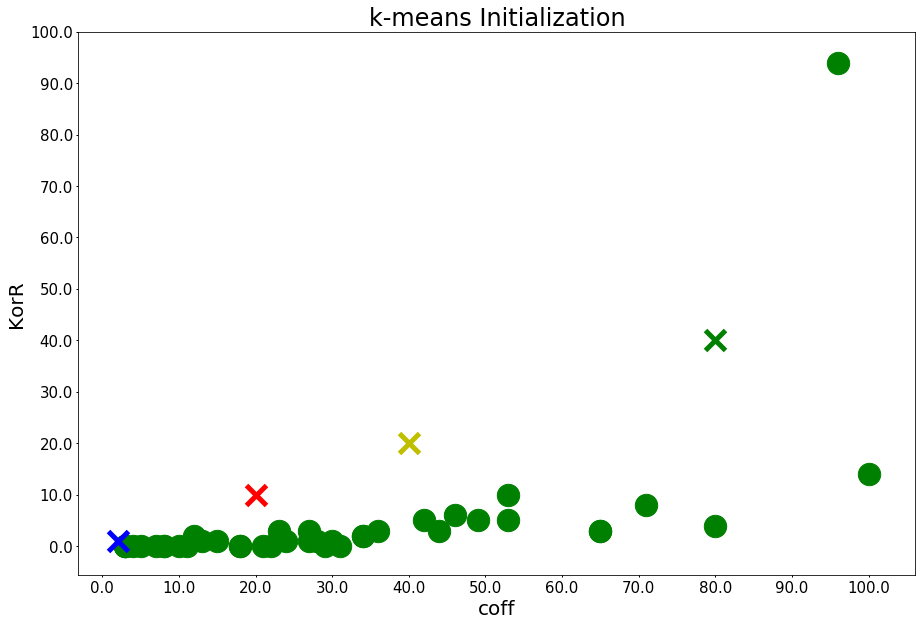

In [137]:
centers = [[2, 1], [20, 10],[40,20],[80,40]]
plot_points(centers, figure_title='k-means Initialization')

Run *k*-means to cluster the neighborhood into 5 clusters.

In [79]:
# set number of clusters
kclusters = 5

manhattan_coffKor_clustering = manhattan_coffKor_sum.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_coffKor_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 1, 0, 0, 4, 4, 1, 0, 3], dtype=int32)

Let's create a new dataframe that includes the cluster.

In [80]:
manhattan_coffK_merged = manhattan_data

# add clustering labels
manhattan_coffK_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_coffK_mergedK = manhattan_coffK_merged.join(manhattan_coffKor_sum.set_index('Neighborhood'), on='Neighborhood')

manhattan_coffK_mergedK.head() # check the last columns!


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,CoffeeShop & Cafe,Korean Restaurant
0,Manhattan,Marble Hill,40.876551,-73.910660,4,3.0,0.0
1,Manhattan,Chinatown,40.715618,-73.994279,4,46.0,6.0
2,Manhattan,Washington Heights,40.851903,-73.936900,1,8.0,0.0
3,Manhattan,Inwood,40.867684,-73.921210,0,8.0,0.0
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0,10.0,0.0


visualize the resulting clusters

In [71]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_coffK_mergedK['Latitude'], manhattan_coffK_mergedK['Longitude'], manhattan_coffK_mergedK['Neighborhood'], manhattan_coffK_mergedK['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Cluster 1

In [83]:
manhattan_coffK_mergedK.loc[manhattan_coffK_mergedK['Cluster Labels'] == 0, manhattan_coffK_mergedK.columns[[1] + list(range(5, manhattan_coffK_mergedK.shape[1]))]]

,Neighborhood,CoffeeShop & Cafe,Korean Restaurant
3,Inwood,8.0,0.0
4,Hamilton Heights,10.0,0.0
8,Upper East Side,18.0,0.0
10,Lenox Hill,29.0,0.0
26,Morningside Heights,27.0,3.0
27,Gramercy,23.0,3.0


#### Cluster 2

In [84]:
manhattan_coffK_mergedK.loc[manhattan_coffK_mergedK['Cluster Labels'] == 1, manhattan_coffK_mergedK.columns[[1] + list(range(5, manhattan_coffK_mergedK.shape[1]))]]

,Neighborhood,CoffeeShop & Cafe,Korean Restaurant
2,Washington Heights,8.0,0.0
7,East Harlem,5.0,0.0
13,Lincoln Square,28.0,1.0
15,Midtown,100.0,14.0
19,East Village,42.0,5.0
20,Lower East Side,11.0,0.0
21,Tribeca,15.0,1.0
22,Little Italy,71.0,8.0
28,Battery Park City,31.0,0.0
30,Carnegie Hill,30.0,1.0


#### Cluster 3

In [85]:
manhattan_coffK_mergedK.loc[manhattan_coffK_mergedK['Cluster Labels'] == 2, manhattan_coffK_mergedK.columns[[1] + list(range(5, manhattan_coffK_mergedK.shape[1]))]]

,Neighborhood,CoffeeShop & Cafe,Korean Restaurant
24,West Village,34.0,2.0


#### Cluster 4

In [86]:
manhattan_coffK_mergedK.loc[manhattan_coffK_mergedK['Cluster Labels'] == 3, manhattan_coffK_mergedK.columns[[1] + list(range(5, manhattan_coffK_mergedK.shape[1]))]]

,Neighborhood,CoffeeShop & Cafe,Korean Restaurant
9,Yorkville,13.0,1.0
12,Upper West Side,18.0,0.0
18,Greenwich Village,65.0,3.0
23,Soho,80.0,4.0
29,Financial District,65.0,3.0


#### Cluster 5

In [87]:
manhattan_coffK_mergedK.loc[manhattan_coffK_mergedK['Cluster Labels'] == 4, manhattan_coffK_mergedK.columns[[1] + list(range(5, manhattan_coffK_mergedK.shape[1]))]]

,Neighborhood,CoffeeShop & Cafe,Korean Restaurant
0,Marble Hill,3.0,0.0
1,Chinatown,46.0,6.0
5,Manhattanville,7.0,0.0
6,Central Harlem,3.0,0.0
11,Roosevelt Island,3.0,0.0
14,Clinton,34.0,2.0
16,Murray Hill,49.0,5.0
17,Chelsea,44.0,3.0
25,Manhattan Valley,12.0,2.0
31,Noho,53.0,5.0


### End of the Capstone project exercise.  Thanks!